In [1]:
from dvt.core import FrameInput
from dvt.core import DataExtraction

from dvt.pipeline.csv import VideoCsvPipeline

#importing different annotators
from dvt.annotate.diff import DiffAnnotator
from dvt.core import DataExtraction, ImageInput
from dvt.annotate.color import ColorHistogramAnnotator, DominantColorAnnotator

%pylab inline

import numpy as np
import scipy as sp
import pandas as pd
import json

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
from os.path import join, basename

Populating the interactive namespace from numpy and matplotlib


In [2]:
fi = FrameInput(input_path=join("bestdressed videos", "Working at American Eagle _ Pay, Discount & My Experience-30Mz637WNnI.mp4"))

In [3]:
dextraction = DataExtraction(fi)

In [4]:
dextraction.run_annotators([
    DiffAnnotator(quantiles=[50])
])

In [5]:
dt = dextraction.get_data()

In [6]:
from dvt.aggregate.cut import CutAggregator
dextraction.run_aggregator(CutAggregator(cut_vals={'q50': 3}, min_len=10))

In [7]:
dt = dextraction.get_data()
dt.keys()
#collections.OrderedDict

odict_keys(['meta', 'diff', 'cut'])

In [8]:
dt['meta']

,type,fps,frames,height,width,input_path,input_bname,input_filename,input_file_extension
0,video,29.97003,17686,720,1280,C:\Users\Gebruiker\Documents\Digital Humanitie...,"Working at American Eagle _ Pay, Discount & My...","Working at American Eagle _ Pay, Discount & My...",.mp4


In [9]:
dt['cut']

,frame_start,frame_end
0,0,563
1,564,916
2,917,1998
3,1999,2899
4,2900,3051
5,3052,3499
6,3500,4123
7,4124,4832
8,4833,6370
9,6371,6859


In [10]:
video_name = dt['meta']['input_filename'].values
total_frames = dt['meta']['frames'].values # this and the above are np array values which are shown
number_shots = len(dt['cut'])

In [11]:
# get video name and video frame as simple string objects and not np array
video_name = video_name.tolist()
video_name = "".join(video_name)

In [12]:
total_frames = total_frames.tolist()
total_frames = total_frames[0]

In [13]:
#investigating the use of color across time and it's impact on viewer attraction

def conf_int(vals, ndigits=1):
    se = 1.96 * np.sqrt(np.var(vals) / len(vals))
    mu = np.mean(vals)
    return [round(mu - se, ndigits=ndigits), round(mu + se, ndigits=ndigits)]


plt.rcParams["figure.figsize"] = (8,8)

In [14]:
img_paths = [join("Screenshots", "Working at American Eagle _ Pay, Discount & My Experience-30Mz637WNnI", x) for x in os.listdir(join("Screenshots", "Working at American Eagle _ Pay, Discount & My Experience-30Mz637WNnI"))]

# accessing the VLC screenshots made per video

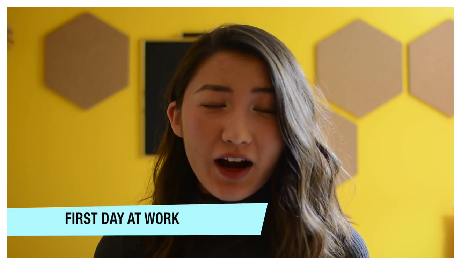

In [15]:
#checking if the right file was accessed 

img = imread(img_paths[(20)]) #specified image index in specified image folder
plt.imshow(img) #shows image with plot axes
_=plt.axis("off") #shows image without plot axes

#not necessary for the rest of the processing code

In [16]:
input_obj = ImageInput(input_paths=img_paths)
dextra = DataExtraction(input_obj)
dextra.run_annotators([
    ColorHistogramAnnotator(num_buckets=(16, 4, 8)),
    DominantColorAnnotator()
])

#output contains metadata, information about the 5 dominant colors in each poster 
# as well as info about the specific hues, values and saturations

dt = dextra.get_json()

dt.keys() #output shows dictionary keys

dict_keys(['meta', 'colorhist', 'domcolor'])

In [17]:
#aggregating information across the corpus
#loading the fully annotated version of the corpus (in the notebook 4 this is in a json file already)

# complex histogram which require some processing

#counting the number of pixels that are dark, heavily saturated, red, and white
#restructure the dominant color info to better integrate into a rectangular dataset

paths = [basename(x['paths']) for x in dt['meta']]

dark_count = np.zeros((len(dt['meta'])))
saturated_count = np.zeros((len(dt['meta'])))
red_count = np.zeros((len(dt['meta'])))
white_count= np.zeros((len(dt['meta'])))
for i, hist in enumerate(dt['colorhist']):
    img_hist = np.array(hist['hsv']).reshape((16, 4, 8))
    dark_count[i] = np.sum(img_hist[:,:,:3])
    saturated_count[i] = np.sum(img_hist[:,3,4:])
    red_count[i] = np.sum(img_hist[:2,2:,4:])
    white_count[i] = np.sum(img_hist[:,0,4:])

    
dom_cols = []
for i, dc in enumerate(dt['domcolor']):
    dom_cols.append(dc['dominant_colors'])

In [18]:
# converting values into a structured table

color_info = pd.DataFrame({
    'img': paths,
    'dark_perc': dark_count / (594 * 4),
    'saturated_perc': saturated_count / (594 * 4), 
    'red_perc': red_count / (594 * 4),
    'white_perc': white_count/ (594 * 4),
    'dom_cols': dom_cols
})
color_info

,img,dark_perc,saturated_perc,red_perc,white_perc,dom_cols
0,scene00001.png,95.133418,122.473064,75.439394,14.670455,"[#1b150d, #774f2e, #b79d7e, #b9921a, #e9d04a]"
1,scene00061.png,88.062290,122.851431,76.190236,15.158249,"[#b89b7d, #ba911a, #e9d04a, #764e2d, #1c140d]"
2,scene00121.png,93.861111,122.706229,73.489057,16.653199,"[#b79b7e, #e9d04a, #ba911a, #754e2f, #1c150f]"
3,scene00181.png,90.955808,120.432660,78.600589,12.986111,"[#1b150d, #b9921a, #794f2f, #ba9d7f, #e9d04a]"
4,scene00241.png,86.744108,121.276094,71.761785,15.321970,"[#b89c7f, #b9921a, #794f2f, #1d150f, #e9d04a]"
...,...,...,...,...,...,...
287,scene17221.png,259.673401,47.451599,48.576599,40.875842,"[#0c0f0e, #34383f, #8d665a, #b78c2b, #bcbac0]"
288,scene17281.png,254.329545,52.983586,48.686027,44.374158,"[#b38b26, #0a0d0d, #2b2e31, #805f57, #b9b6bb]"
289,scene17341.png,268.835438,30.691077,34.059343,38.693603,"[#313336, #8c675a, #c0bbbd, #0c0f0e, #c59e36]"
290,scene17401.png,255.489899,53.044192,45.354377,43.009259,"[#0a0d0d, #84635b, #2d3133, #b48b23, #babac0]"


In [19]:
dark_perc_std = color_info['dark_perc'].std()
dark_perc_mean = color_info['dark_perc'].mean()

saturated_perc_std = color_info['saturated_perc'].std()
saturated_perc_mean = color_info['saturated_perc'].mean()

red_perc_std = color_info['red_perc'].std()
red_perc_mean = color_info['red_perc'].mean()

white_perc_std = color_info['white_perc'].std()
white_perc_mean = color_info['white_perc'].mean()

In [20]:
#accessing json file for additional meta-data --> likes, dislikes, shares, views, date posted 

In [21]:
import json
import glob

In [22]:
with open ("C:/Users/Gebruiker/Documents/Digital Humanities/block 3/Thesis Lab/scraping YouTube data/metadata/Working at American Eagle _ Pay, Discount & My Experience-30Mz637WNnI.info.json") as json_file:
    metadata = json.load(json_file)

In [23]:
category = metadata['categories']
categories = "".join(category)
tags = metadata['tags']
view_count = metadata['view_count']
like_count = metadata['like_count']
dislike_count = metadata['dislike_count']
upload_date = metadata['upload_date']

In [24]:
tags_str = ", ".join(tags)

In [25]:
print(tags_str)

working at american eagle, american eagle job, american eagle orientation, american eagle pay, american eagle employee discount, how to get a job at american eagle, how to get hired at american eagle, my experience working at american eagle, my job at american eagle, working for american eagle, working retail, retail job experience, aeo job, working at ae, how much does american eagle pay, job at american eagle, american eagle job experience, american eagle experience


# Saving the files

In [26]:
# save pd to csv file for general info specific to this video
color_info.to_csv("C:/Users/Gebruiker/Documents/Digital Humanities/Thesis/dvt bestdressed csv/Working at American Eagle _ Pay, Discount & My Experience-30Mz637WNnI.csv")

In [27]:
#open csv file and make into pd df
# insert new data as row in pd df
# save csv again
import csv

In [28]:
field = [video_name, upload_date, categories, view_count, like_count, dislike_count, total_frames, number_shots, dark_perc_std, dark_perc_mean, saturated_perc_std, saturated_perc_mean, red_perc_std, red_perc_mean, white_perc_std, white_perc_mean, tags_str]

In [29]:
with open('data for video analysis.csv', 'a') as infile:
    infileWriter=csv.writer(infile)
    infileWriter.writerow(field)